In [17]:
import os
from utils import DataSeq, load_ids

import numpy as np
import pandas as pd
import skimage.io as io

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.losses import Loss

import keras_tuner as kt

from imblearn.over_sampling import RandomOverSampler

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [18]:
path = "./Train_non_experts_simple/"
batch_size = 8
epochs = 10

In [19]:
ids, labels = load_ids(path)
print(ids.shape, labels.shape)
X_train, X_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, random_state=42)
print(y_train.shape, y_valid.shape)

(75243,) (75243, 3)
(60194, 3) (15049, 3)


In [7]:
# Loading images with generator

train_seq = DataSeq(X_train, y_train)
valid_seq = DataSeq(X_valid, y_valid)

train_steps = len(X_train) // batch_size
valid_steps = len(X_valid) // batch_size

In [20]:
# Loading images in numpy array instead of generator

# WARNING: USES A LOT OF RAM!!!

X_train_list = np.array([(io.imread(image_path) / 255.0) for image_path in X_train[:2000]])
X_valid_list = np.array([(io.imread(image_path) / 255.0) for image_path in X_valid[:250]])
y_train = np.array(y_train[:2000])
y_valid = np.array(y_valid[:250])

In [21]:
print(X_train_list.shape, X_valid_list.shape)
print(y_train.shape, y_valid.shape)
print(type(X_train_list))

(2000, 224, 224, 3) (250, 224, 224, 3)
(2000, 3) (250, 3)
<class 'numpy.ndarray'>


# Focal loss

In [8]:
# This function receives onehot encoded labels
def calculate_weigths(y):
    y = np.argmax(y, axis=-1)
    counts = np.unique(y, return_counts=True)[1]
    weights = 1 / (counts / len(y))
    sum_weights = np.sum(weights)
    return weights / sum_weights

class FocalLoss(Loss):
    def __init__(self, gamma=2.0, alpha=None, num_classes=None):
        super().__init__()
        self.gamma = gamma
        if num_classes is None:
            raise ValueError("The 'num_classes' parameter must be specified.")
        if alpha is None:
            alpha = [1 for _ in range(num_classes)]
        elif len(alpha) != num_classes:
            raise ValueError("The length of 'alpha' must be equal to 'num_classes'.")
        self.alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)

    def call(self, y_true, y_pred):
        if y_true.shape != y_pred.shape:
            raise ValueError(f"Invalid shape: y_true {y_true.shape} != y_pred {y_pred.shape}")
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.clip_by_value(y_pred, clip_value_min= 1e-6, clip_value_max=1-1e-6)

        entropy = -tf.math.log(y_pred) * y_true

        weight = tf.math.pow(1.0 - y_pred, self.gamma)
        loss = self.alpha * weight * entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))


# Hyperparameter Tuning

In [14]:
WEIGTHS = calculate_weigths(labels)

def build_transfer_vgg_aug(hp):
    input_layer = Input(shape=(224, 224, 3))

    data_augmentation = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.15),
    ])
    
    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=data_augmentation.output)
    vgg.load_weights('./vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)
    model = Dense(4096, activation='relu')(model)
    model = Dropout(0.25)(model)

    model = Dense(3, activation='softmax')(model)

    gamma = hp.Float("gamma", min_value=1.0, max_value=5.0, step=0.5)
    model = Model(input_layer, model, name="Transfer_VGG16")
    
    #model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.compile(optimizer="adam", loss=FocalLoss(gamma, WEIGTHS), metrics=["accuracy"])
    return model

In [15]:
obj = kt.Objective("val_loss", "min")

tuner = kt.BayesianOptimization(
    hypermodel=build_transfer_vgg_aug,
    objective=obj,
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='./tuner_results/',
    project_name='Bayesian_Focal_loss',
)

tuner.search_space_summary()

Search space summary
Default search space size: 1
gamma (Float)
{'default': 1.0, 'conditions': [], 'min_value': 1.0, 'max_value': 5.0, 'step': 0.5, 'sampling': 'linear'}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# This call is for images using a generator/sequence
tuner.search(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
    validation_steps=valid_steps, epochs=10, callbacks=[stop_early])

# This call is for images in a numpy array
# tuner.search(X_train_list, y_train, validation_data=(X_valid_list, y_valid), batch_size=32, epochs=10)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1.5               |1.5               |gamma

Epoch 1/10
Tensor("IteratorGetNext:1", shape=(None, 3), dtype=float32) Tensor("Transfer_VGG16/dense_1/Softmax:0", shape=(None, 3), dtype=float32)
Tensor("IteratorGetNext:1", shape=(None, 3), dtype=float32) Tensor("Transfer_VGG16/dense_1/Softmax:0", shape=(None, 3), dtype=float32)
63/63 [==============================] - 13s 186ms/step - loss: 2.2707 - accuracy: 0.3685 - val_loss: 2.2874 - val_accuracy: 0.4000
Epoch 2/10
63/63 [==============================] - 8s 117ms/step - loss: 2.2967 - accuracy: 0.3725 - val_loss: 2.2874 - val_accuracy: 0.4000
Epoch 3/10
63/63 [==============================] - 7s 117ms/step - loss: 2.2967 - accuracy: 0.3725 - val_loss: 2.2874 - val_accuracy: 0.4000
Epoch 4/10
63/63 [==============================] - 7s 117ms/step - loss: 2.2967 - accuracy: 0.3725 - val_loss: 2.2874 - val_accuracy: 0.4000
Epoch 5/10
63/63 [==================

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal gamma is {best_hps.get('gamma')}")

In [16]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "Transfer_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                        
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                    

In [12]:
tuner.results_summary()

Results summary
Results in ./tuner_results/Bayesian
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 01 summary
Hyperparameters:
image_rotation_factor: 0.15000000000000002
neurons: 2048
layers: 1
dropout: 0.1
Score: 0.37971675395965576

Trial 02 summary
Hyperparameters:
image_rotation_factor: 0.15000000000000002
neurons: 2048
layers: 1
dropout: 0.30000000000000004
Score: 0.3816812336444855

Trial 08 summary
Hyperparameters:
image_rotation_factor: 0.2
neurons: 2048
layers: 1
dropout: 0.35
Score: 0.39233091473579407

Trial 05 summary
Hyperparameters:
image_rotation_factor: 0.5
neurons: 2048
layers: 1
dropout: 0.30000000000000004
Score: 0.3940642476081848

Trial 06 summary
Hyperparameters:
image_rotation_factor: 0.225
neurons: 2048
layers: 1
dropout: 0.30000000000000004
Score: 0.3981710970401764

Trial 04 summary
Hyperparameters:
image_rotation_factor: 0.475
neurons: 1024
layers: 2
dropout: 0.1
Score: 0.4033352732658386

Trial 07 summary
Hyperparameters:
image_rot

In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_seq, validation_data=valid_seq, steps_per_epoch=train_steps,
 validation_steps=valid_steps, epochs=10, callbacks=[stop_early])

Epoch 1/10
11172/11172 [==============================] - 538s 48ms/step - loss: 0.4956 - accuracy: 0.8073 - val_loss: 0.4272 - val_accuracy: 0.8226
Epoch 2/10
11172/11172 [==============================] - 533s 48ms/step - loss: 0.4253 - accuracy: 0.8268 - val_loss: 0.4218 - val_accuracy: 0.8323
Epoch 3/10
11172/11172 [==============================] - 534s 48ms/step - loss: 0.4103 - accuracy: 0.8327 - val_loss: 0.4798 - val_accuracy: 0.8173
Epoch 4/10
11172/11172 [==============================] - 532s 48ms/step - loss: 0.4032 - accuracy: 0.8365 - val_loss: 0.4001 - val_accuracy: 0.8457
Epoch 5/10
11172/11172 [==============================] - 536s 48ms/step - loss: 0.3974 - accuracy: 0.8391 - val_loss: 0.3988 - val_accuracy: 0.8347
Epoch 6/10
11172/11172 [==============================] - 538s 48ms/step - loss: 0.3940 - accuracy: 0.8409 - val_loss: 0.4130 - val_accuracy: 0.8300
Epoch 7/10
11172/11172 [==============================] - 536s 48ms/step - loss: 0.3891 - accuracy: 0.8419

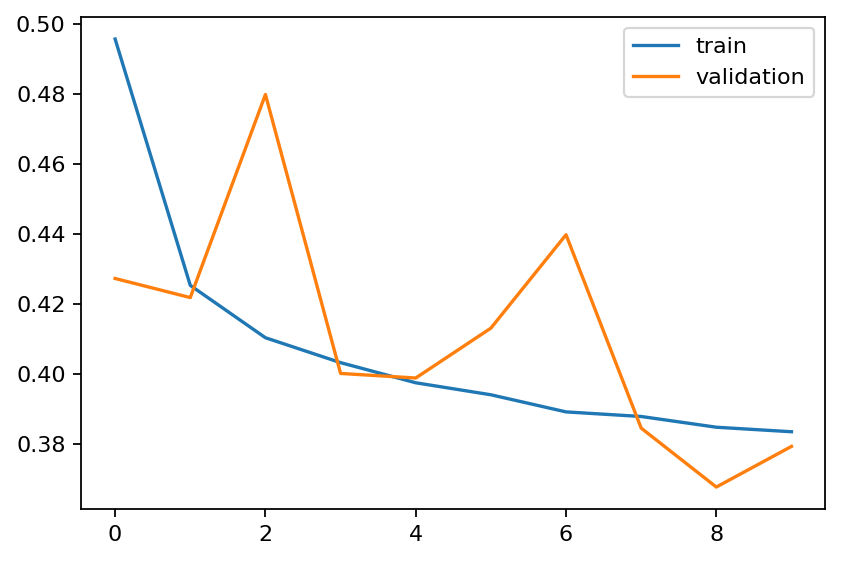

In [18]:
plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.show()

In [19]:
test_path = "./Test/"
test_ids, test_labels = load_ids(test_path)
test_seq = DataSeq(test_ids, test_labels)

In [20]:
y_pred = model.predict(test_seq)
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(np.argmax(test_labels, axis=1), y_pred))


546/546 [==============================] - 18s 32ms/step
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2692
           1       0.63      0.80      0.70      1196
           2       0.73      0.76      0.74       476

    accuracy                           0.78      4364
   macro avg       0.75      0.78      0.76      4364
weighted avg       0.80      0.78      0.79      4364



In [21]:
 model.save_weights('./bcss_aug_weights_focal_loss.h5')